In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
import copy
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats
import networkx as nx
import re


import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 20
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

In [3]:
df_nc = pd.read_csv("../results/results_node_classification.csv")
df_nc.head()

,model,with_features,nc_test_size,Beta_s,gamma_s,Ns_obs,kmean_s,gamma_n,kmean_n,gamma_f,N_f,Beta_bi,nu,alpha,N_labels,accuracy
0,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,-1.0,2.0,63.171387
1,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,-1.0,3.0,47.005000
2,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,-1.0,6.0,24.591247
3,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,-1.0,10.0,14.350384
4,GAT_Euclidean,1.0,0.7,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,1.0,2.0,59.578255


In [4]:
all_params_without_i = ['with_features', 'lp_test_size', 'Beta_s', 'gamma_s', 'Ns_obs', 'kmean_s',
                        'gamma_n', 'kmean_n', 'gamma_f', 'N_f', 'Beta_bi', 'nu']

df_lp = pd.read_csv("../results/results_link_prediction.csv")
# Aggregate over i's
df_lp = df_lp.groupby(['model', *all_params_without_i]).agg({'AUC': 'mean', 'ap': 'mean', 'prc': 'mean'}).reset_index()

df_lp.head()

,model,with_features,lp_test_size,Beta_s,gamma_s,Ns_obs,kmean_s,gamma_n,kmean_n,gamma_f,N_f,Beta_bi,nu,AUC,ap,prc
0,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,1.1,0.0,75.706833,73.760052,57.465933
1,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,2.1,2000.0,3.0,0.0,76.665890,75.597791,58.274483
2,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,3.5,2000.0,1.1,0.0,75.519199,73.277213,57.351168
3,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,3.0,3.5,2000.0,3.0,0.0,75.382790,73.489528,57.112622
4,GAT_Euclidean,1.0,0.1,1.1,2.1,5000.0,3.0,2.1,30.0,2.1,2000.0,1.1,0.0,82.574855,80.256614,63.757734


In [5]:
my_order = ['MLP_Euclidean', 'HNN_PoincareBall', 'GCN_Euclidean', 'GAT_Euclidean', 'HGCN_PoincareBall']
my_colors = list(sns.color_palette("colorblind"))
my_pallete = dict(zip(my_order, my_colors))
my_pairs = [
        (my_order[0], my_order[1]),
        (my_order[1], my_order[2]),
        (my_order[2], my_order[3]),
        (my_order[3], my_order[4]),
        (my_order[2], my_order[4]),
    ]

### Fig. S1 (unipartite parameters)

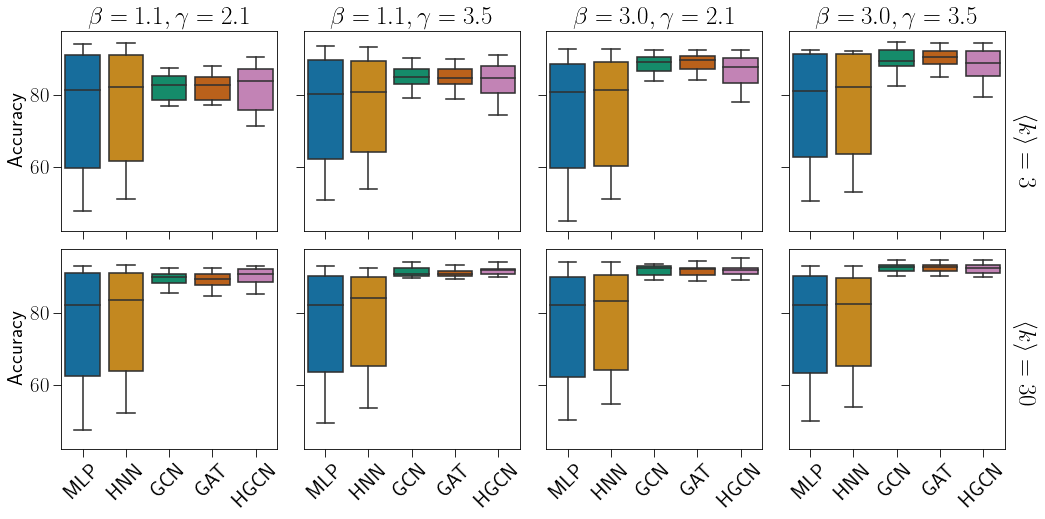

In [6]:
from statannotations.Annotator import Annotator

fig, axs = plt.subplots(2, 4, sharey=True, figsize=(14, 7))


df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]

i = 0
for label_kmean, group_kmean in df_nc_tmp.groupby('kmean_s'):
    j = 0
    for label_beta_gamma, group_beta_gamma in group_kmean.groupby(['Beta_s', 'gamma_s']):
        
        g = sns.boxplot(data=group_beta_gamma, y='accuracy', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')
        
        # From https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00
#         annotator = Annotator(axs[i, j], my_pairs, data=group_beta_gamma, 
#                               x='model', y='accuracy', order=my_order, verbose=False)
#         annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
#         annotator.apply_and_annotate()
         
        if i == 0:
            axs[i, j].set_title(rf'$\beta={{{label_beta_gamma[0]}}}, \gamma={{{label_beta_gamma[1]}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='Accuracy')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 55, rf'$\left<k\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.5)

# plt.savefig("/home/rob/Dropbox/BenchmarkFeatures/Paper/KDD/SI/plots/fig1_unipartite_nc.pdf")

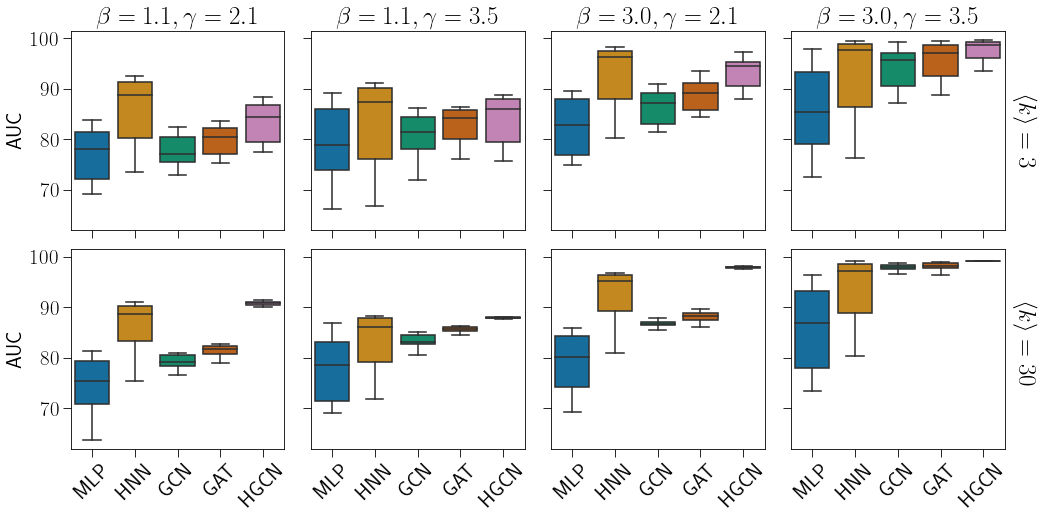

In [7]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(14, 7))

i = 0
for label_kmean, group_kmean in df_lp.groupby('kmean_s'):
    j = 0
    for label_beta_gamma, group_beta_gamma in group_kmean.groupby(['Beta_s', 'gamma_s']):
        
        g = sns.boxplot(data=group_beta_gamma, y='AUC', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')
        
        if i == 0:
            axs[i, j].set_title(rf'$\beta={{{label_beta_gamma[0]}}}, \gamma={{{label_beta_gamma[1]}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='AUC')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 75, rf'$\left<k\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.5)

# plt.savefig("/home/rob/Dropbox/BenchmarkFeatures/Paper/KDD/SI/plots/fig1_unipartite_lp.pdf")

### Fig S1 (bipartite parameters)

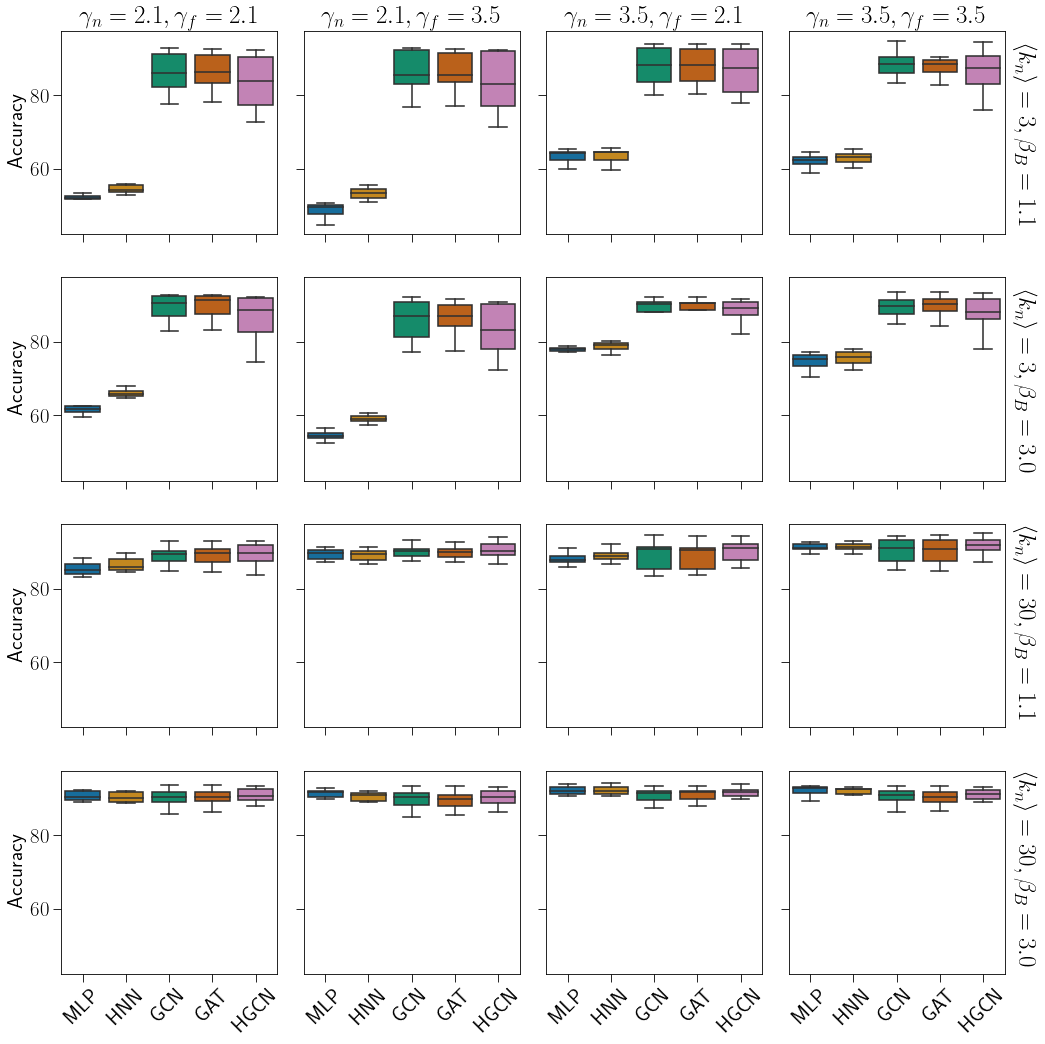

In [8]:
fig, axs = plt.subplots(4, 4, sharey=True, figsize=(14, 14))

df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]

i = 0
for label_kmean_beta, group_kmean_beta in df_nc_tmp.groupby(['kmean_n', 'Beta_bi']):
    j = 0
    for label_gammas, group_gammas in group_kmean_beta.groupby(['gamma_n', 'gamma_f']):
        
        g = sns.boxplot(data=group_gammas, y='accuracy', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')
         
        if i == 0:
            axs[i, j].set_title(rf'$\gamma_n={{{label_gammas[0]}}}, \gamma_f={{{label_gammas[1]}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i in [0, 1, 2]:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='Accuracy')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 45, rf'$\left<k_n\right>={{{label_kmean_beta[0]:.0f}}}, \beta_B={{{label_kmean_beta[1]}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.5)


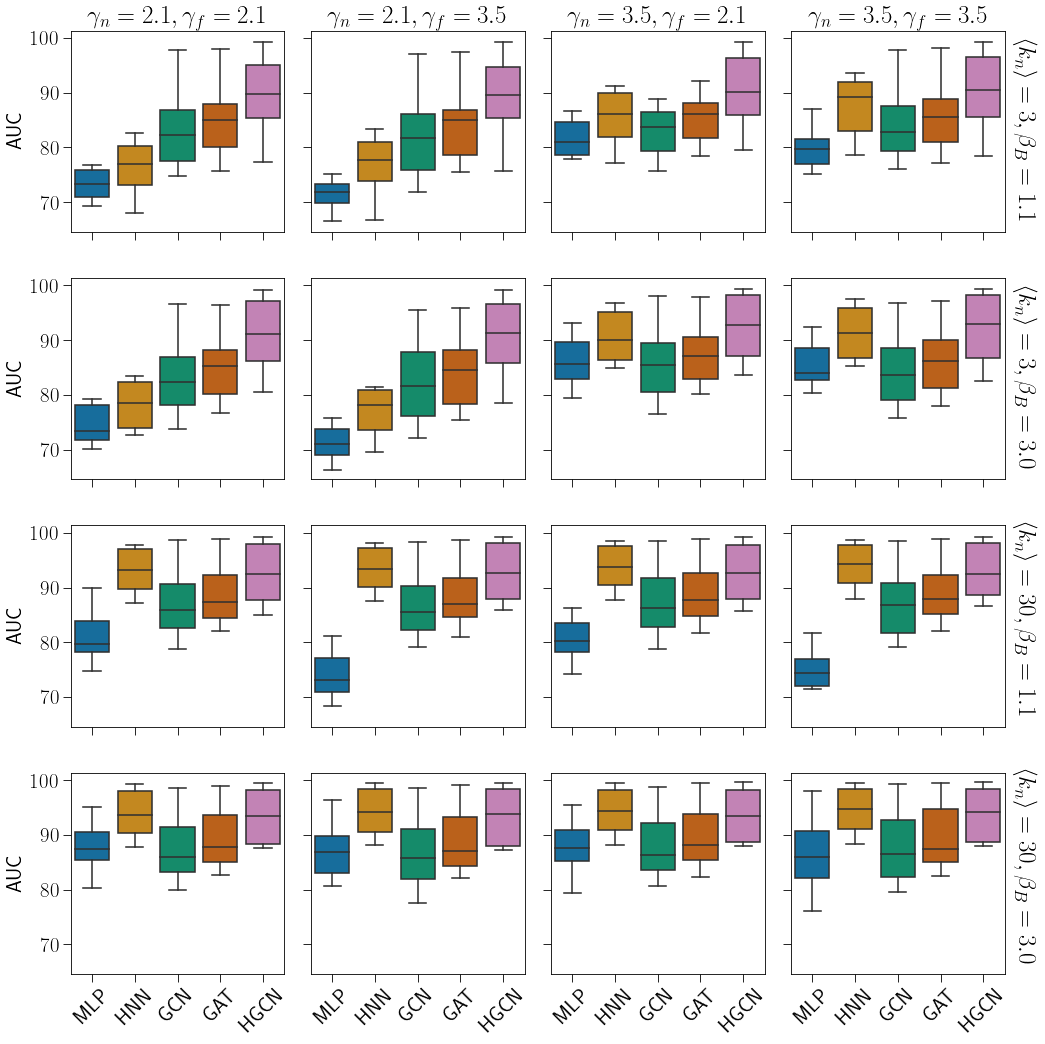

In [9]:
fig, axs = plt.subplots(4, 4, sharey=True, figsize=(14, 14))

i = 0
for label_kmean_beta, group_kmean_beta in df_lp.groupby(['kmean_n', 'Beta_bi']):
    j = 0
    for label_gammas, group_gammas in group_kmean_beta.groupby(['gamma_n', 'gamma_f']):
        
        g = sns.boxplot(data=group_gammas, y='AUC', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')
         
        if i == 0:
            axs[i, j].set_title(rf'$\gamma_n={{{label_gammas[0]}}}, \gamma_f={{{label_gammas[1]}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i in [0, 1, 2]:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='AUC')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 67, rf'$\left<k_n\right>={{{label_kmean_beta[0]:.0f}}}, \beta_B={{{label_kmean_beta[1]}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.5)


### Fig S1 (mixed parameters)

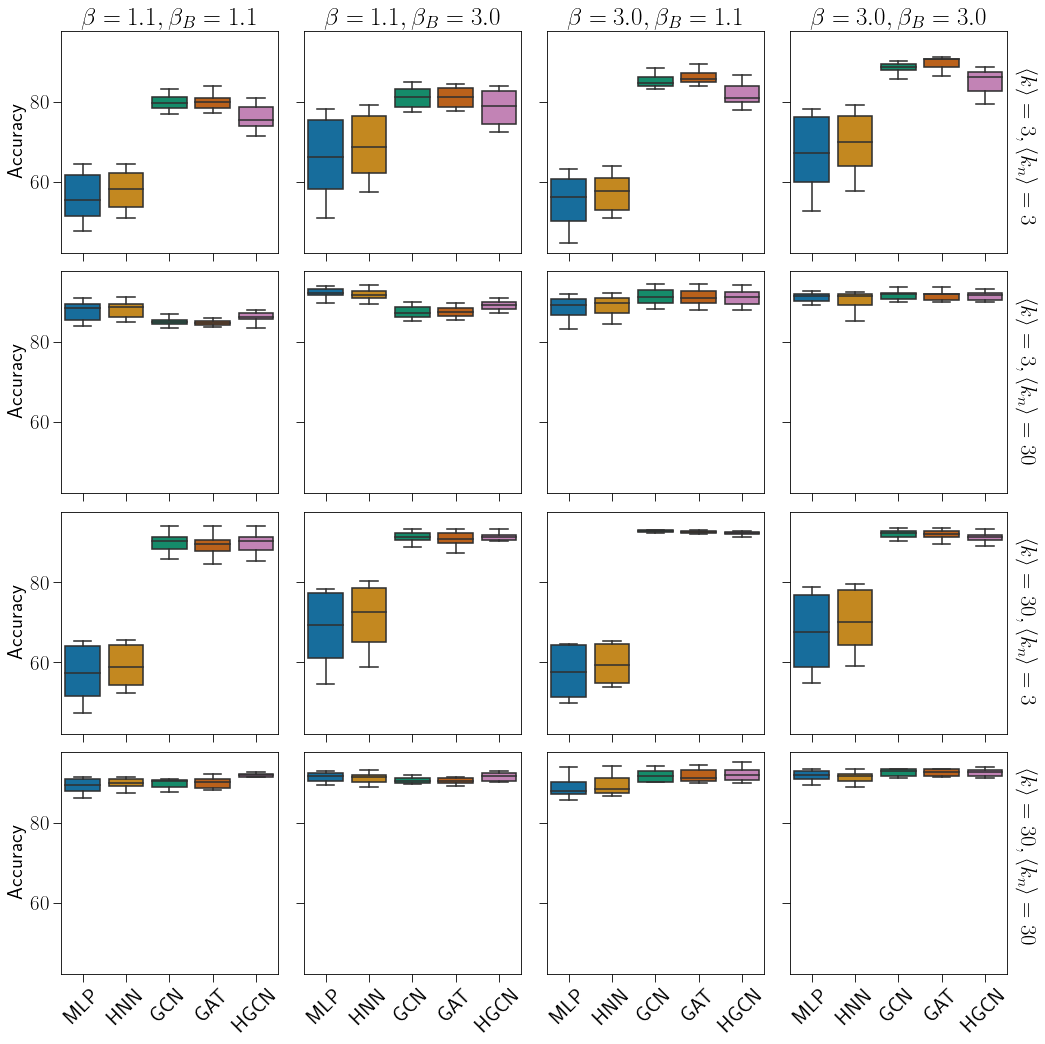

In [10]:
fig, axs = plt.subplots(4, 4, sharey=True,  sharex=True, figsize=(14, 14))

df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]

i = 0
for label_kmean, group_kmean in df_nc_tmp.groupby(['kmean_s', 'kmean_n']):
    j = 0
    for label_beta1_beta2, group_beta1_beta2 in group_kmean.groupby(['Beta_s', 'Beta_bi']):
        
        g = sns.boxplot(data=group_beta1_beta2, y='accuracy', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')
         
        if i == 0:
            axs[i, j].set_title(rf'$\beta={{{label_beta1_beta2[0]}}}, \beta_B={{{label_beta1_beta2[1]}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        
        if i in [0, 1, 2]:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='Accuracy')
        else:
            g.set(ylabel='')
        j += 1
    
    axs[i, j-1].text(4.7, 50, rf'$\left<k\right>={{{label_kmean[0]:.0f}}}, \left<k_n\right>={{{label_kmean[1]:.0f}}}$', rotation=270, fontsize=22)
    i += 1
    
plt.subplots_adjust(hspace=0)
plt.tight_layout(pad=0.5)


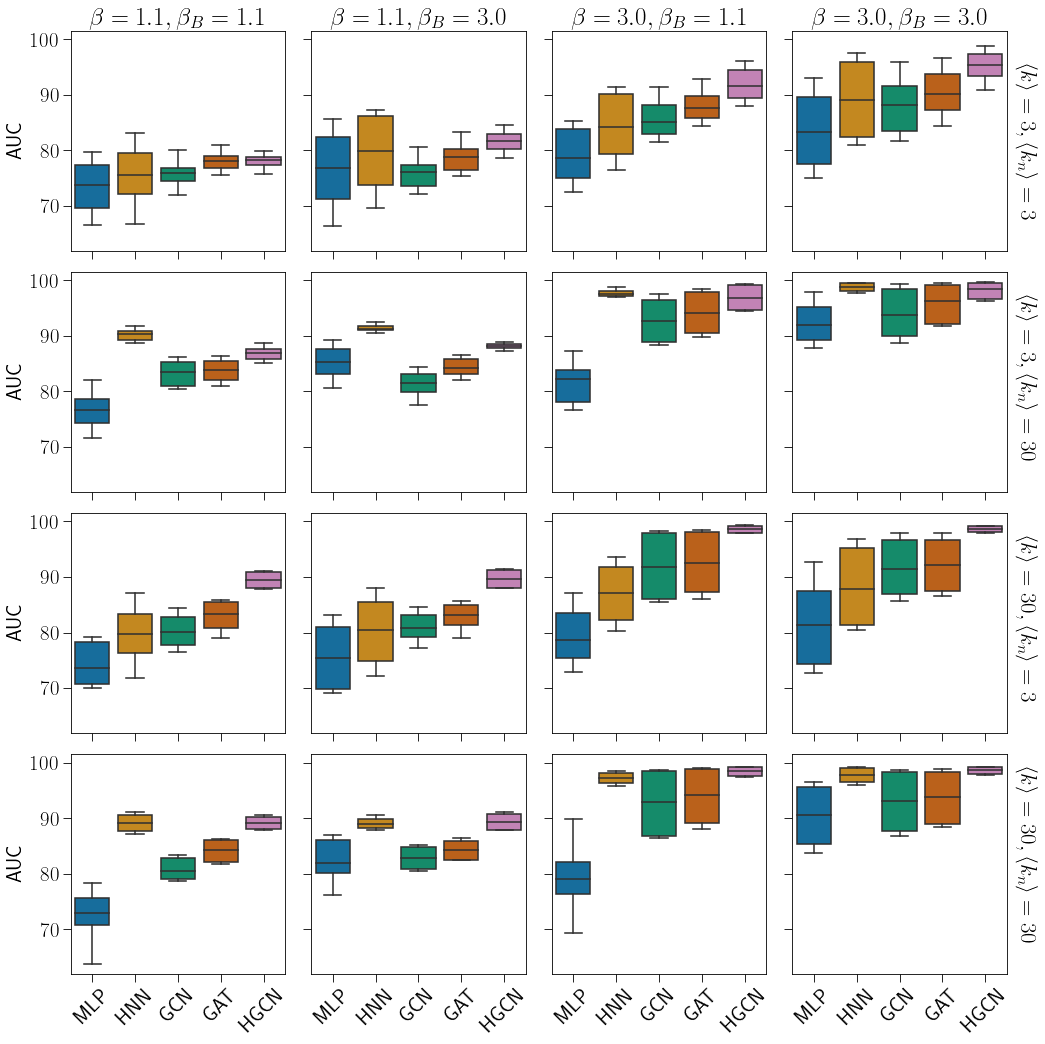

In [11]:
fig, axs = plt.subplots(4, 4, sharey=True,  sharex=True, figsize=(14, 14))

i = 0
for label_kmean, group_kmean in df_lp.groupby(['kmean_s', 'kmean_n']):
    j = 0
    for label_beta1_beta2, group_beta1_beta2 in group_kmean.groupby(['Beta_s', 'Beta_bi']):
        
        g = sns.boxplot(data=group_beta1_beta2, y='AUC', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')
         
        if i == 0:
            axs[i, j].set_title(rf'$\beta={{{label_beta1_beta2[0]}}}, \beta_B={{{label_beta1_beta2[1]}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        
        if i in [0, 1, 2]:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='AUC')
        else:
            g.set(ylabel='')
        j += 1
    
    axs[i, j-1].text(4.7, 68, rf'$\left<k\right>={{{label_kmean[0]:.0f}}}, \left<k_n\right>={{{label_kmean[1]:.0f}}}$', rotation=270, fontsize=22)
    i += 1
    
plt.subplots_adjust(hspace=0)
plt.tight_layout(pad=0.5)


---
---

### Fig 2. node classification only

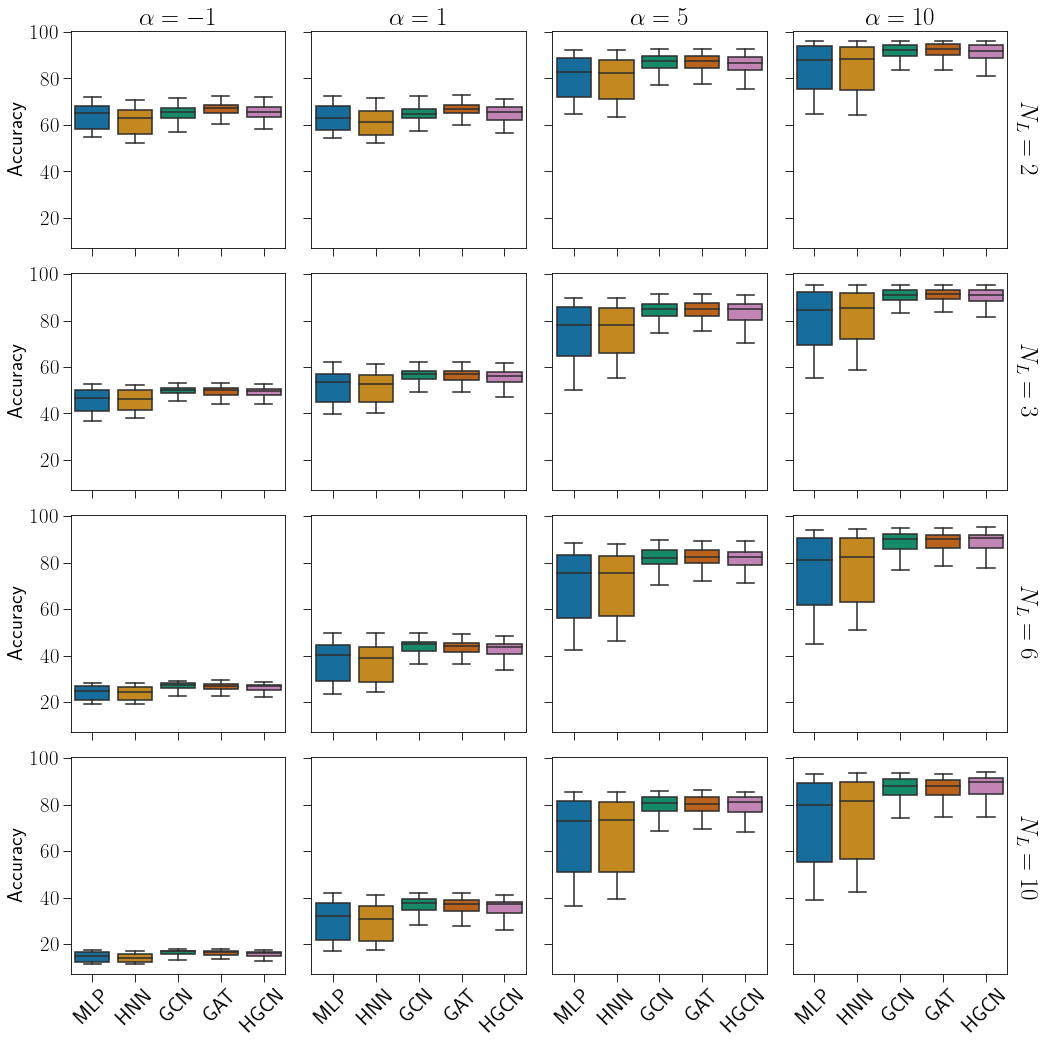

In [12]:
from statannotations.Annotator import Annotator

fig, axs = plt.subplots(4, 4, sharey=True, figsize=(14, 14))


i = 0
for label_n_labels, group_n_labels in df_nc.groupby('N_labels'):
    j = 0
    for label_alpha, group_alpha in group_n_labels.groupby('alpha'):
        
        g = sns.boxplot(data=group_alpha, y='accuracy', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')

        if i == 0:
            axs[i, j].set_title(rf'$\alpha={{{label_alpha:.0f}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i in [0, 1, 2]:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='Accuracy')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 40, rf'$N_L={{{label_n_labels:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.5)


---
---

## Fig for publication

In [13]:
def plot_per_param(df_nc, df_lp, col, val, title, ax):
    tmp_nc = df_nc[df_nc[col] == val].groupby('model').agg({'accuracy': 'mean'}).reset_index()
    tmp_lp = df_lp[df_lp[col] == val].groupby('model').agg({'AUC': 'mean'}).reset_index()
    tmp = tmp_nc.merge(tmp_lp)
    
    sorter = ['MLP_Euclidean', 'HNN_PoincareBall', 'GCN_Euclidean', 'GAT_Euclidean', 'HGCN_PoincareBall']
    tmp.sort_values(by="model", key=lambda column: column.map(lambda e: sorter.index(e)), inplace=True)
    tmp.reset_index(drop=True, inplace=True)
    
    for idx, row in tmp.iterrows():
        ax.scatter(row['AUC'], row['accuracy'], label=row['model'].split('_')[0], 
                   color=colors[idx], marker=markers[idx], edgecolors='black', s=300, lw=1.5, alpha=0.8)
    ax.set_title(title)

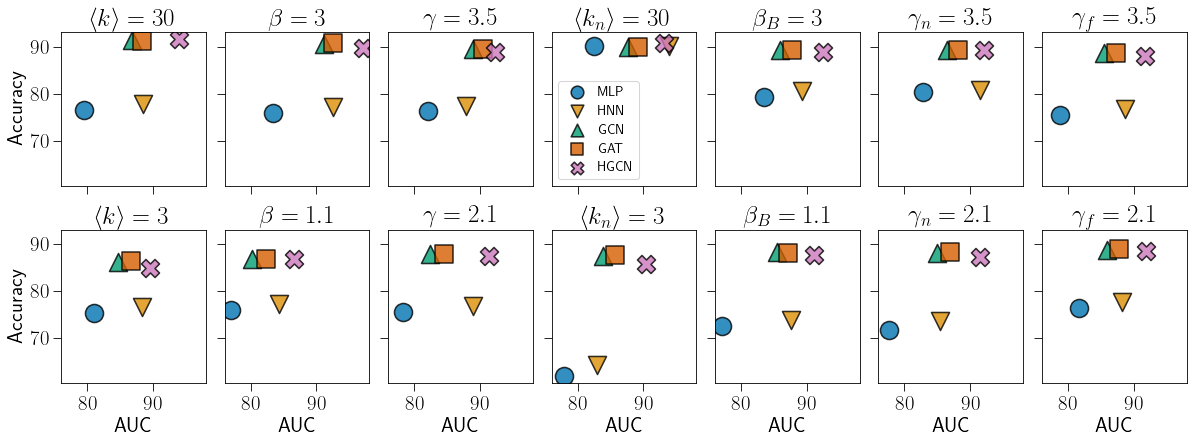

In [14]:
markers = ['o', 'v', '^', 's', 'X', 'P']
colors = list(sns.color_palette("colorblind"))

fig, axs = plt.subplots(2, 7, sharey=True, sharex=True, figsize=(16, 6))

df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]


# high vs low <k>
plot_per_param(df_nc_tmp, df_lp, 'kmean_s', 30, r'$\left<k\right>=30$', axs[0, 0])
plot_per_param(df_nc_tmp, df_lp, 'kmean_s', 3, r'$\left<k\right>=3$', axs[1, 0])

# high vs low beta
plot_per_param(df_nc_tmp, df_lp, 'Beta_s', 3.0, r'$\beta=3$', axs[0, 1])
plot_per_param(df_nc_tmp, df_lp, 'Beta_s', 1.1, r'$\beta=1.1$', axs[1, 1])

# high vs low gamma
plot_per_param(df_nc_tmp, df_lp, 'gamma_s', 3.5, r'$\gamma=3.5$', axs[0, 2])
plot_per_param(df_nc_tmp, df_lp, 'gamma_s', 2.1, r'$\gamma=2.1$', axs[1, 2])

# high vs low <k_n>
plot_per_param(df_nc_tmp, df_lp, 'kmean_n', 30, r'$\left<k_n\right>=30$', axs[0, 3])
axs[0, 3].legend(fontsize=13, scatterpoints=1, markerscale=0.7, handletextpad=0.5)
plot_per_param(df_nc_tmp, df_lp, 'kmean_n', 3, r'$\left<k_n\right>=3$', axs[1, 3])

# high vs low beta_bi
plot_per_param(df_nc_tmp, df_lp, 'Beta_bi', 3.0, r'$\beta_B=3$', axs[0, 4])
plot_per_param(df_nc_tmp, df_lp, 'Beta_bi', 1.1, r'$\beta_B=1.1$', axs[1, 4])

# high vs low gamma_n
plot_per_param(df_nc_tmp, df_lp, 'gamma_n', 3.5, r'$\gamma_n=3.5$', axs[0, 5])
plot_per_param(df_nc_tmp, df_lp, 'gamma_n', 2.1, r'$\gamma_n=2.1$', axs[1, 5])

# high vs low gamma_n
plot_per_param(df_nc_tmp, df_lp, 'gamma_f', 3.5, r'$\gamma_f=3.5$', axs[0, 6])
plot_per_param(df_nc_tmp, df_lp, 'gamma_f', 2.1, r'$\gamma_f=2.1$', axs[1, 6])


axs[0, 0].set_ylabel(r'Accuracy')
axs[1, 0].set_ylabel(r'Accuracy')
[axs[1, x].set_xlabel(r'AUC') for x in range(7)]

plt.tight_layout(pad=0.5)


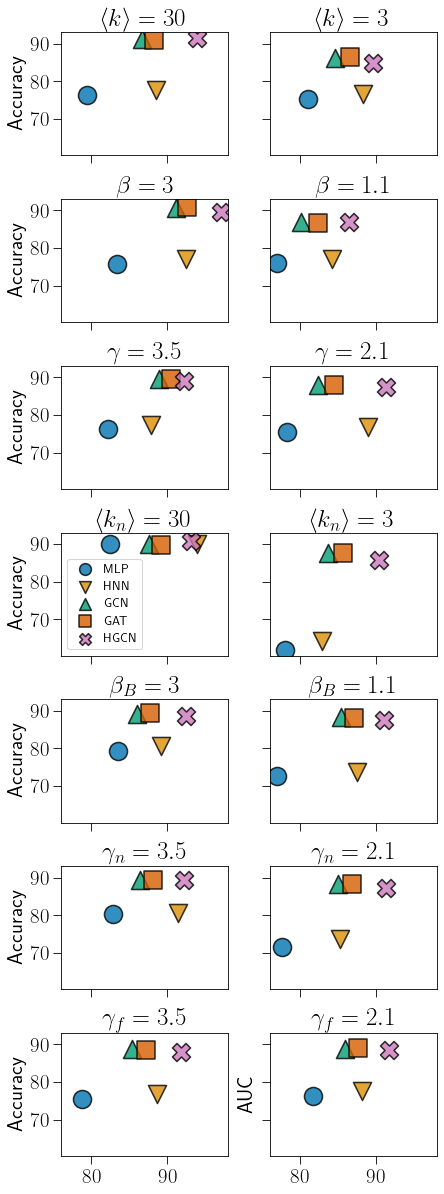

In [15]:
markers = ['o', 'v', '^', 's', 'X', 'P']
colors = list(sns.color_palette("colorblind"))

fig, axs = plt.subplots(7, 2, sharey=True, sharex=True, figsize=(6, 16))

df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]

# high vs low <k>
plot_per_param(df_nc_tmp, df_lp, 'kmean_s', 30, r'$\left<k\right>=30$', axs[0, 0])
plot_per_param(df_nc_tmp, df_lp, 'kmean_s', 3, r'$\left<k\right>=3$', axs[0, 1])

# high vs low beta
plot_per_param(df_nc_tmp, df_lp, 'Beta_s', 3.0, r'$\beta=3$', axs[1, 0])
plot_per_param(df_nc_tmp, df_lp, 'Beta_s', 1.1, r'$\beta=1.1$', axs[1, 1])

# high vs low gamma
plot_per_param(df_nc_tmp, df_lp, 'gamma_s', 3.5, r'$\gamma=3.5$', axs[2, 0])
plot_per_param(df_nc_tmp, df_lp, 'gamma_s', 2.1, r'$\gamma=2.1$', axs[2, 1])

# high vs low <k_n>
plot_per_param(df_nc_tmp, df_lp, 'kmean_n', 30, r'$\left<k_n\right>=30$', axs[3, 0])
axs[3, 0].legend(fontsize=12, scatterpoints=1, markerscale=0.65, handletextpad=0.5)
plot_per_param(df_nc_tmp, df_lp, 'kmean_n', 3, r'$\left<k_n\right>=3$', axs[3, 1])

# high vs low beta_bi
plot_per_param(df_nc_tmp, df_lp, 'Beta_bi', 3.0, r'$\beta_B=3$', axs[4, 0])
plot_per_param(df_nc_tmp, df_lp, 'Beta_bi', 1.1, r'$\beta_B=1.1$', axs[4, 1])

# high vs low gamma_n
plot_per_param(df_nc_tmp, df_lp, 'gamma_n', 3.5, r'$\gamma_n=3.5$', axs[5, 0])
plot_per_param(df_nc_tmp, df_lp, 'gamma_n', 2.1, r'$\gamma_n=2.1$', axs[5, 1])

# high vs low gamma_n
plot_per_param(df_nc_tmp, df_lp, 'gamma_f', 3.5, r'$\gamma_f=3.5$', axs[6, 0])
plot_per_param(df_nc_tmp, df_lp, 'gamma_f', 2.1, r'$\gamma_f=2.1$', axs[6, 1])


axs[6, 0].set_ylabel(r'AUC')
axs[6, 1].set_ylabel(r'AUC')
[axs[x, 0].set_ylabel(r'Accuracy') for x in range(7)]

plt.tight_layout(pad=0.5)


---
---

### Fig for publication

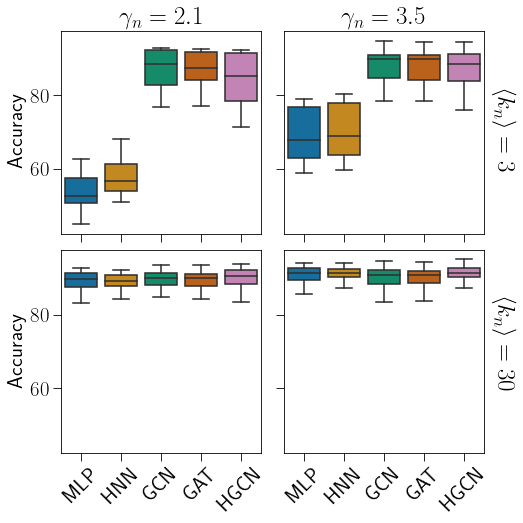

In [16]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 7))

df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]

i = 0
for label_kmean, group_kmean in df_nc_tmp.groupby('kmean_n'):
    j = 0
    for label_gamma, group_gamma in group_kmean.groupby('gamma_n'):
        
        g = sns.boxplot(data=group_gamma, y='accuracy', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')

         
        if i == 0:
            axs[i, j].set_title(rf'$\gamma_n={{{label_gamma}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='Accuracy')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 60, rf'$\left<k_n\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.4)


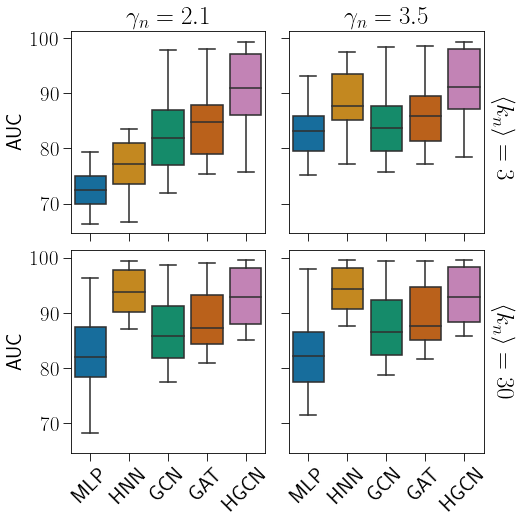

In [17]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 7))


i = 0
for label_kmean, group_kmean in df_lp.groupby('kmean_n'):
    j = 0
    for label_gamma, group_gamma in group_kmean.groupby('gamma_n'):
        
        g = sns.boxplot(data=group_gamma, y='AUC', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')
         
        if i == 0:
            axs[i, j].set_title(rf'$\gamma_n={{{label_gamma}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='AUC')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 75, rf'$\left<k_n\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.4)


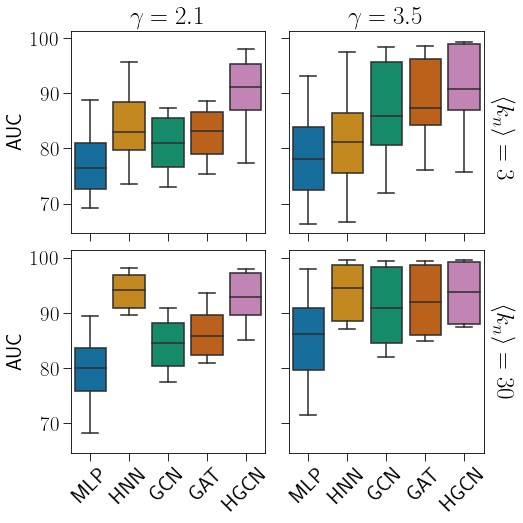

In [18]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 7))


i = 0
for label_kmean, group_kmean in df_lp.groupby('kmean_n'):
    j = 0
    for label_gamma, group_gamma in group_kmean.groupby('gamma_s'):
        
        g = sns.boxplot(data=group_gamma, y='AUC', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')

         
        if i == 0:
            axs[i, j].set_title(rf'$\gamma={{{label_gamma}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='AUC')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 75, rf'$\left<k_n\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.4)


---

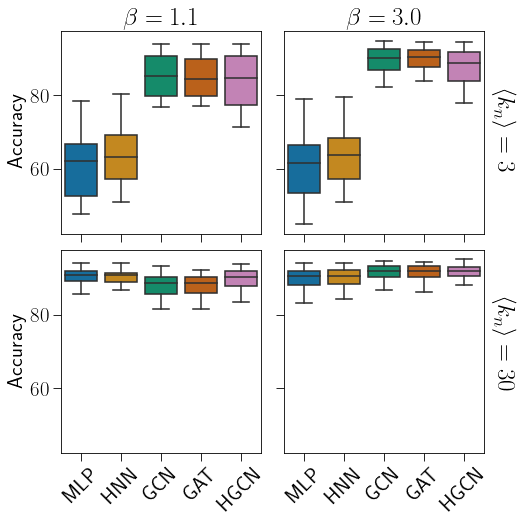

In [19]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 7))

df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]

i = 0
for label_kmean, group_kmean in df_nc_tmp.groupby('kmean_n'):
    j = 0
    for label_gamma, group_gamma in group_kmean.groupby('Beta_s'):
        
        g = sns.boxplot(data=group_gamma, y='accuracy', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')

        if i == 0:
            axs[i, j].set_title(rf'$\beta={{{label_gamma}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='Accuracy')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 60, rf'$\left<k_n\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.4)


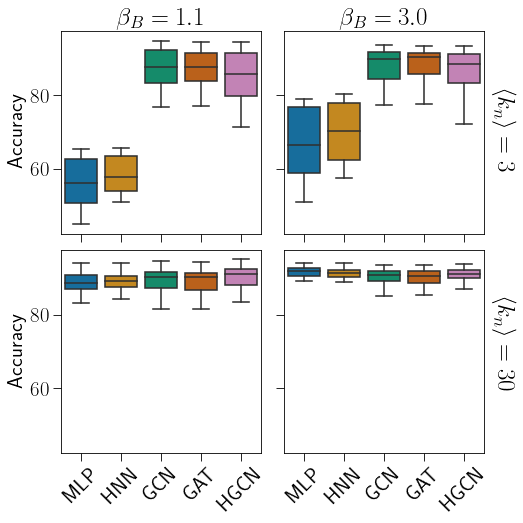

In [241]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 7))

df_nc_tmp = df_nc[(df_nc['N_labels'] == 6) & (df_nc['alpha'] == 10)]

i = 0
for label_kmean, group_kmean in df_nc_tmp.groupby('kmean_n'):
    j = 0
    for label_gamma, group_gamma in group_kmean.groupby('Beta_bi'):
        
        g = sns.boxplot(data=group_gamma, y='accuracy', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')

        if i == 0:
            axs[i, j].set_title(rf'$\beta_B={{{label_gamma}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='Accuracy')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 60, rf'$\left<k_n\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.4)

# plt.savefig("/home/rob/Dropbox/BenchmarkFeatures/Paper/KDD/plots/panel_nc_boxplot_beta_bi_kappa_n.pdf")

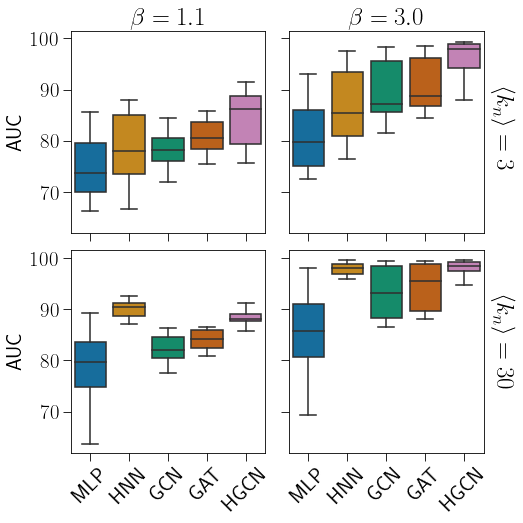

In [20]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 7))


i = 0
for label_kmean, group_kmean in df_lp.groupby('kmean_n'):
    j = 0
    for label_gamma, group_gamma in group_kmean.groupby('Beta_s'):
        
        g = sns.boxplot(data=group_gamma, y='AUC', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')

         
        if i == 0:
            axs[i, j].set_title(rf'$\beta={{{label_gamma}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='AUC')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 75, rf'$\left<k_n\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.4)


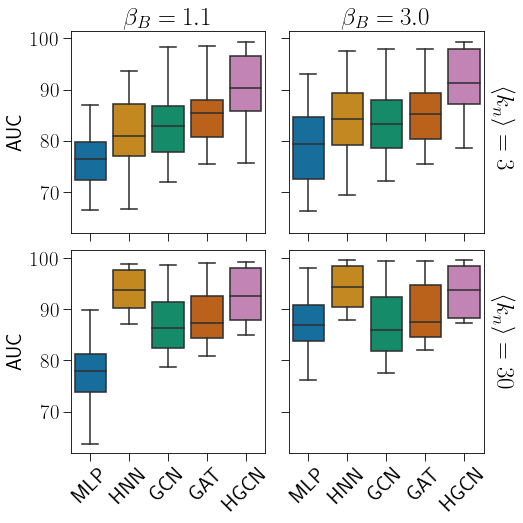

In [21]:
fig, axs = plt.subplots(2, 2, sharey=True, figsize=(7, 7))


i = 0
for label_kmean, group_kmean in df_lp.groupby('kmean_n'):
    j = 0
    for label_gamma, group_gamma in group_kmean.groupby('Beta_bi'):
        
        g = sns.boxplot(data=group_gamma, y='AUC', x='model', linewidth=1.5,
                        order=my_order, palette=my_pallete, ax=axs[i, j], showfliers=False)
        g.set(xlabel='')

         
        if i == 0:
            axs[i, j].set_title(rf'$\beta_B={{{label_gamma}}}$')
        xticks = [f"{t.get_text().split('_')[0]}" for t in g.get_xticklabels()]
        g.set_xticklabels(xticks, rotation=45)
        if i == 0:
            g.set(xticklabels=[])
            
        if j == 0:
            g.set(ylabel='AUC')
        else:
            g.set(ylabel='')
            
        
        j += 1
    
    # Add kmean label
    axs[i, j-1].text(4.7, 75, rf'$\left<k_n\right>={{{label_kmean:.0f}}}$', rotation=270, fontsize=24)
    i += 1
    
plt.tight_layout(pad=0.4)
